# Aereal photograph considering city sprawl

CODIGO CREADO POR ING: RAUL MEJIA

The **Municipality of Cuenca in Ecuador (South America)** requires a new aereal photograph for the urban area which will be used in the general update of parcels next year. The coverage will be defined jointly by the Cadastre department and the Planning department.

The Planning Department has the actual limit of the urban area, however they adviced the Cadastre Department that the limit is not up to date and has to be modified in order to cover the sprawling of the city. The Planning Department wants to include all areas in the city with a **density of 30 or more residential units per hectare**.

The Cadastre department knows that the the cadastral database is not complete, specially in the outer areas of the city, so there is no possibility to use this data source to calculate the areas with the density required. The Cadastre Department contacted the local Electricity Company who has electricity meters for the whole city, geoferenced and with 100% coverage. It will be assumed that each electricity meter represents one residential unit. 

The Cadastre Department will process the electricity meters data source in order to identify the zones with the required density which will be defined in the near future as "urban", areas with lower density will remain as "rural". The aereal photograph will cover only urban areas.


## Clustering

In order to identify areas with the specified density having as data source the electricity meters, a clustering method will be selected. The method selected is DB-SCAN because it is not affected by the shape of the clusters (people tend to live along the routes so clusters with long shapes will be present) and also because the density can be heterogeneous, specially in a city like Cuenca where there are "parroquias" old centers that have origin from the spaniard colonies.

## Python libraries

The electricity meters are stored in a geopackage file therefore the PANDAS library will be used for reading and plottin.
The DBSCAN algorithm will be used from sklearn, a machine learning library available in PYTHON.
The NUMPY library is required by DBSCAN which use arrays.
Other support libraries are used for reading files and plotting.

In [1]:
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN

## Reading the point data from the local electricity company

The meters from the electricity company are stored in a geopackage file as georeferenced points using the UTM Z17S coordinate system. The file is located in the data subfolder and contains more than 200 K meters distributed in a administrative area called "canton". The administrative center of the canton is the ciy of Cuenca, an urban area, around the center we have the rural area.

In [2]:
data_pkg_path = 'data'
filename = 'cuenca_electricity_meters.gpkg'

path = os.path.join(data_pkg_path, filename)
path

meters_gdf = gpd.read_file(path, layer='electricity_meters')
print(meters_gdf.info())
print(meters_gdf.geometry)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 223156 entries, 0 to 223155
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   geometry  223156 non-null  geometry
dtypes: geometry(1)
memory usage: 1.7 MB
None
0         POINT (726105.043 9682562.657)
1         POINT (721962.153 9691465.142)
2         POINT (721975.731 9686074.153)
3         POINT (726145.658 9683021.133)
4         POINT (722529.971 9679117.016)
                       ...              
223151    POINT (724373.282 9678926.419)
223152    POINT (722797.464 9680669.932)
223153    POINT (720270.932 9681768.274)
223154    POINT (680728.853 9700216.037)
223155    POINT (723189.576 9681781.738)
Name: geometry, Length: 223156, dtype: geometry


## Plotting the distribution of meters as points

The density of electricity meters in the urban area and sorrounding rural areas makes impossible to visually delineate an urban area considering a target density.

<AxesSubplot:>

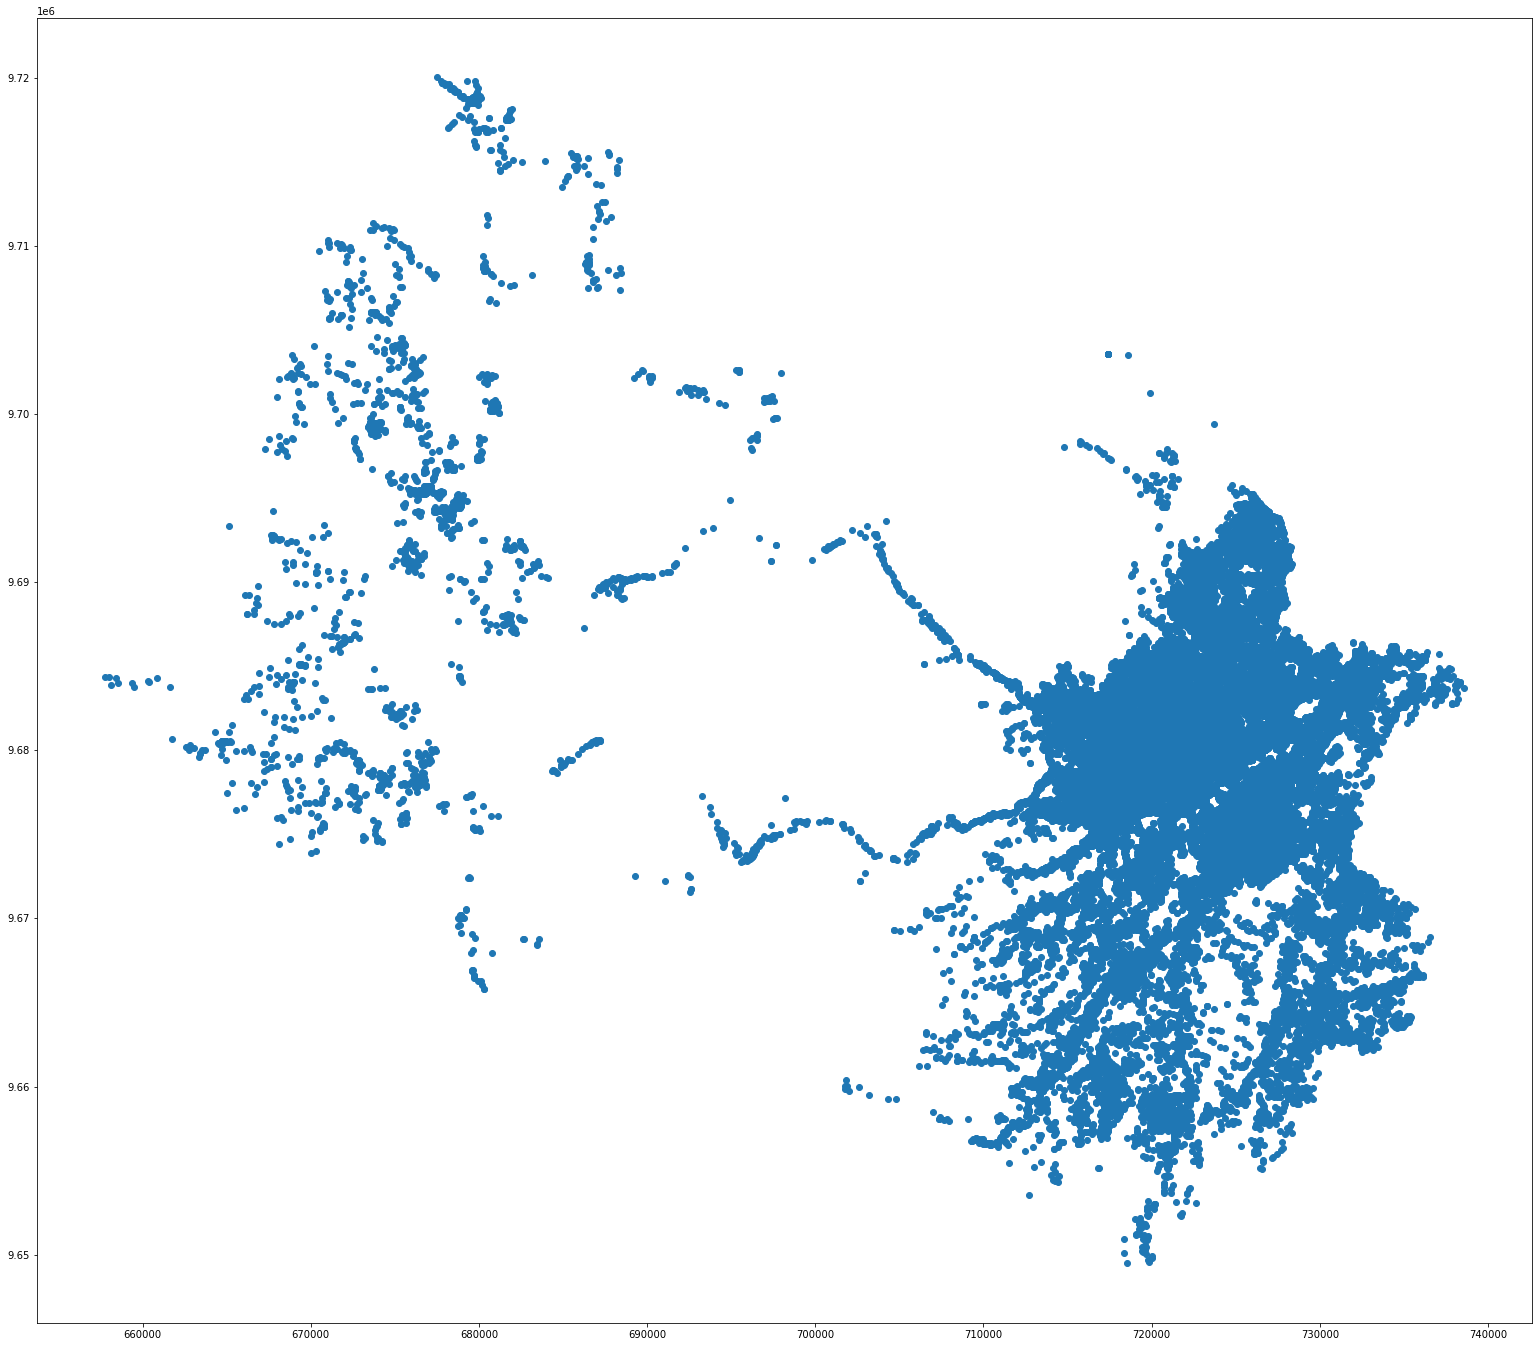

In [3]:
meters_gdf.plot(figsize=(36,24))

Here is when it is useful to use a clustering tool which receives as a parameter a required density. The density is calculated as the number of residential units divided by the area. In the other hand,
DBSCAN requires two parameters:
- EPS: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
- MIN_SAMPLES: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.



## Calculation of parameters for DBSCAN

The Planning deparment asked for areas with a density of 30 or more residential units per hectare. We need to derive the DBSCAN parameters from the density required.
Having the density of 30 residential units per hectare we need the following assumptions:
- The target areas will be formed by at least four blocks (urban areas have basic services as drink water and sewage, therefore streets to locate the networks)
- Each block will be 100x100 meters (spanish style)
- Average street wide will be 8 meters
- Eache block will have in average 30 residential units.

With this assumptions is possible to calculate the EPS and MIN_SAMPLES required by DB_SCAN as is depicted in the graph below.

![title](img/DBSCANparametersFromResidentialUnitsDensity.PNG)

![title](img/DBSCANcalculation.PNG)

According to the graph above we have:
- EPS = R1 = 176.98
- MIN_SAMPLES = 4 blocks * 30 residential units = 120
    
**Therefore in order to get a density of 30 residential units by hectare in groups of 4 blocks we will use the above values in the call to DBSCAN.**

## Creating an array of coordinates from geopandas

DBSCAN requires an array of coordinates so we get them from geopandas.

In [4]:
x = meters_gdf.geometry.centroid.x
y = meters_gdf.geometry.centroid.y

x_array = x.to_numpy()
y_array = y.to_numpy()

print(x_array)
print(y_array)

xy_array = np.column_stack((x_array, y_array))
print(xy_array)

[726105.043    721962.15275  721975.731    ... 720270.9325   680728.853375
 723189.576   ]
[9682562.657   9691465.14175 9686074.153   ... 9681768.274   9700216.0375
 9681781.738  ]
[[ 726105.043    9682562.657   ]
 [ 721962.15275  9691465.14175 ]
 [ 721975.731    9686074.153   ]
 ...
 [ 720270.9325   9681768.274   ]
 [ 680728.853375 9700216.0375  ]
 [ 723189.576    9681781.738   ]]


## Call to DBSCAN

Now we have all the parameters required by the clustering method DBSCAN

In [5]:
dbscn_meters = DBSCAN(eps=176.98, min_samples=120).fit(xy_array)

From DBSCAN we get an array which "labels" every electricity meter according to the cluster it belows. When a meter is not clustered it receive the label -1.
The label is used to plot with different colors every electricity meter.

C:\Users\raul\anaconda3\envs\python_foundation_project\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

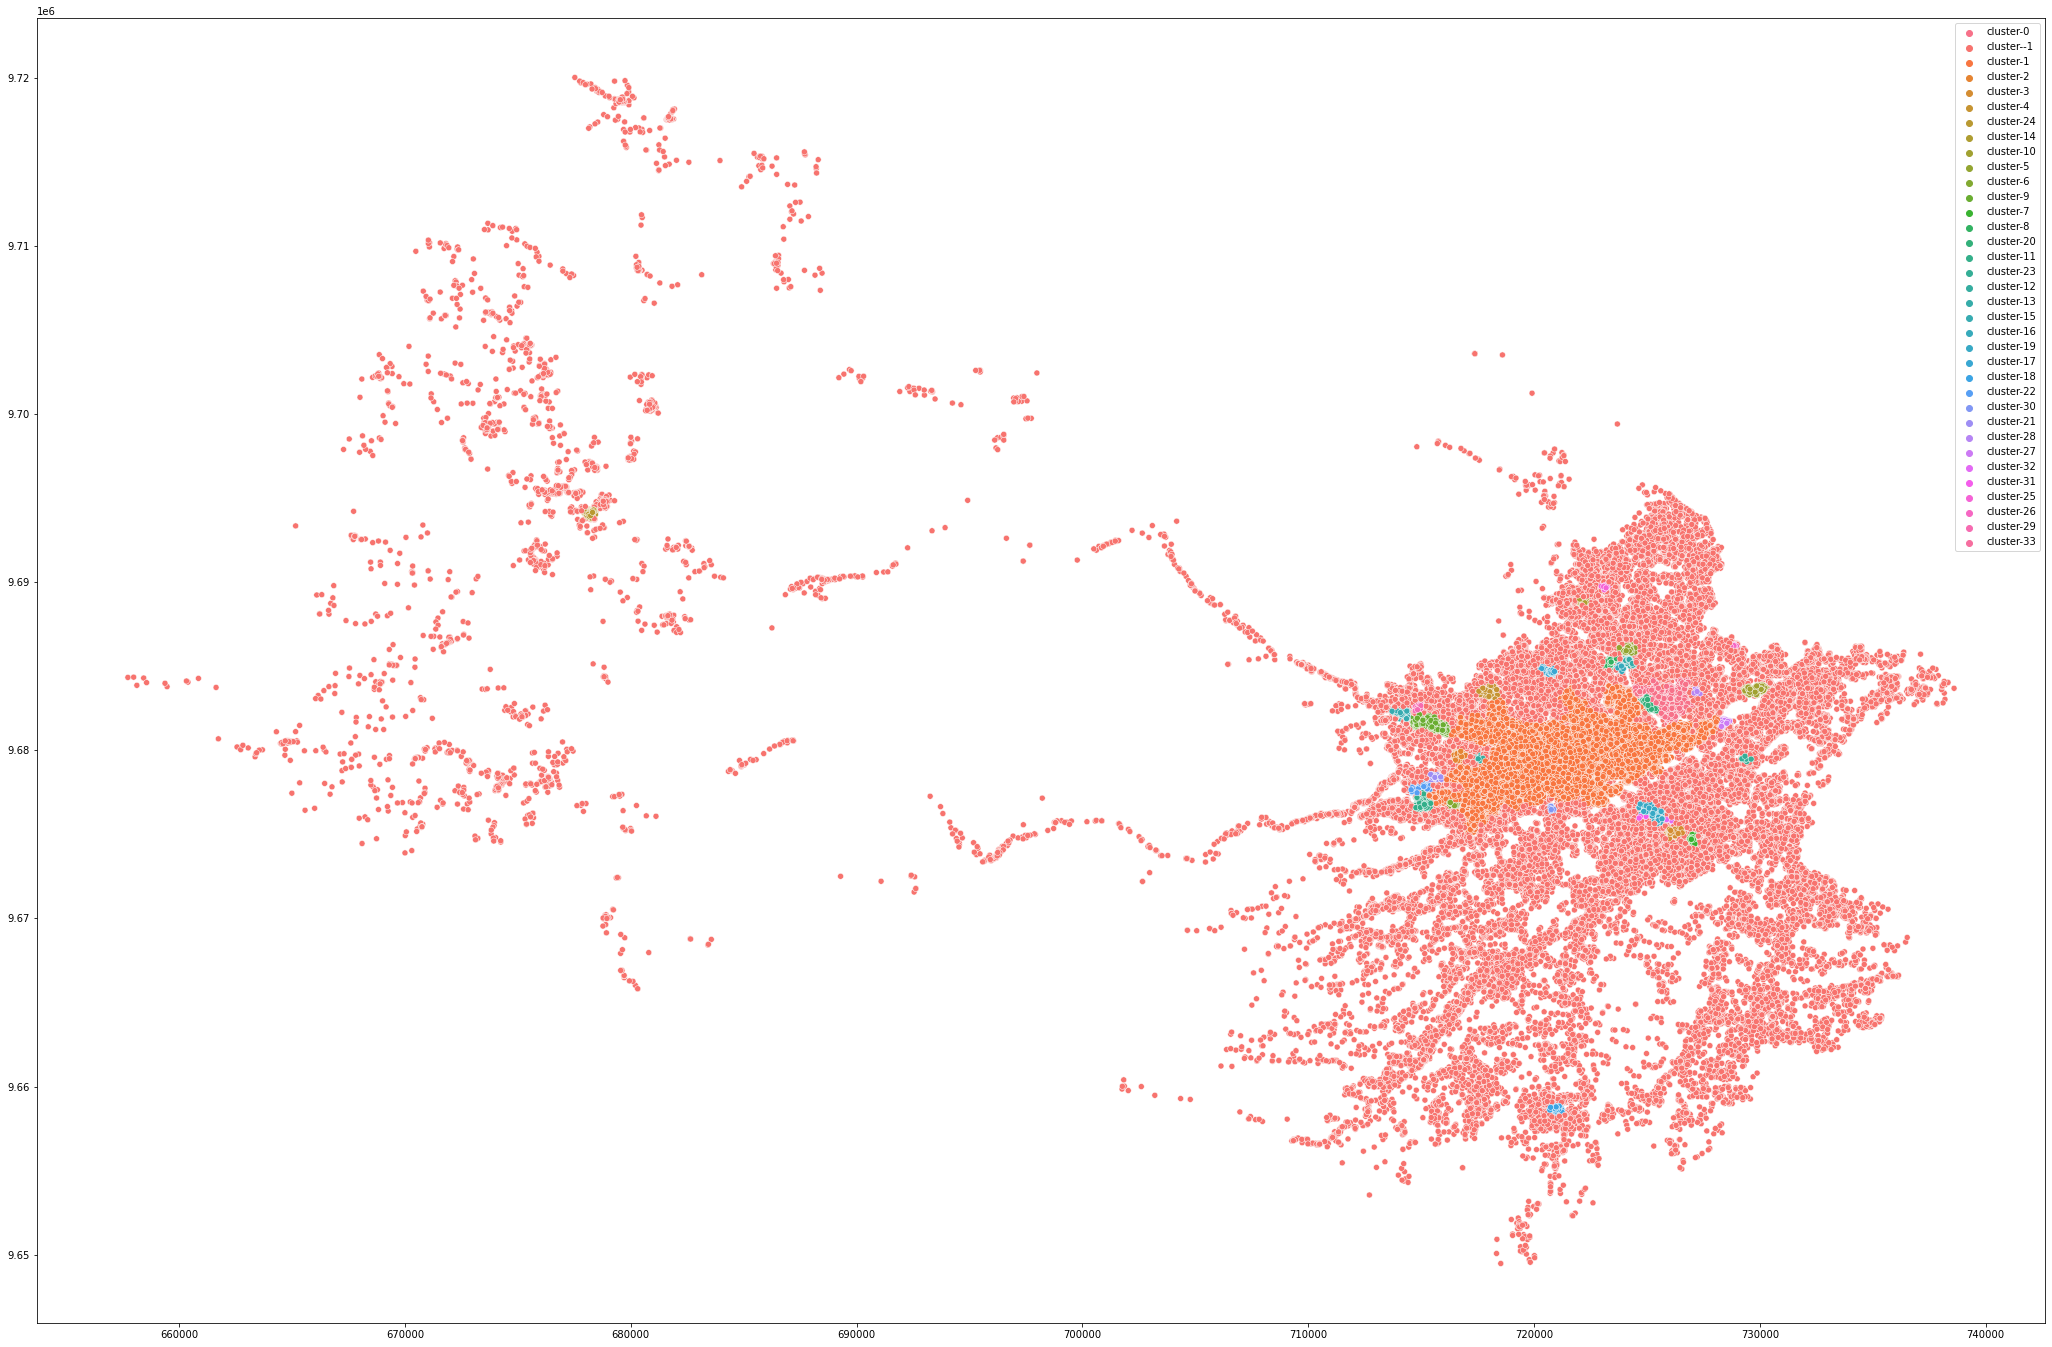

In [6]:
labels_meters = dbscn_meters.labels_
fig_meters = plt.figure(figsize=(36, 24))
sns.scatterplot(xy_array[:,0], xy_array[:,1], hue=["cluster-{}".format(x) for x in labels_meters])


## Plotting only clustered meters (density required) and filtering the not clustered ones (noise)

Only the electricity meters which are surrounded by at least 120 other electricity meters in a radio distance of 176.98 m (and the ones wich are in a distance of 176.98 from them) are clusterd and labelled with a number different of -1. Those clustered electricity meters are fulfill the requirements of a density of 30 residential units per hectare, which is required by the Planning Department and are areas wich must be covered by the aereal photograph.

The electricity meters not clustered (labelled with -1) are considered noise and must be descarted. In the following code the -1 electricity meters are filtered.

In [7]:
no_noise = labels_meters != -1
print(no_noise)

xy_array_no_noise = xy_array[no_noise]
print(xy_array_no_noise)

labels_meters_no_noise = labels_meters[no_noise]
print(labels_meters_no_noise)

[ True False False ... False False  True]
[[ 726105.043    9682562.657   ]
 [ 726145.658    9683021.133   ]
 [ 722529.970875 9679117.016375]
 ...
 [ 724373.282    9678926.419   ]
 [ 722797.464    9680669.932   ]
 [ 723189.576    9681781.738   ]]
[0 0 1 ... 1 1 1]


## Plotting the results

Finally we have only electricity meters that fulfill the requirements to be labelled as being in a the density required.
The result will be presented to the Planning deparment and they can delineate the urban areas with a density of 30 residential units per hectare which will be covered by the aereal photograph.

C:\Users\raul\anaconda3\envs\python_foundation_project\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

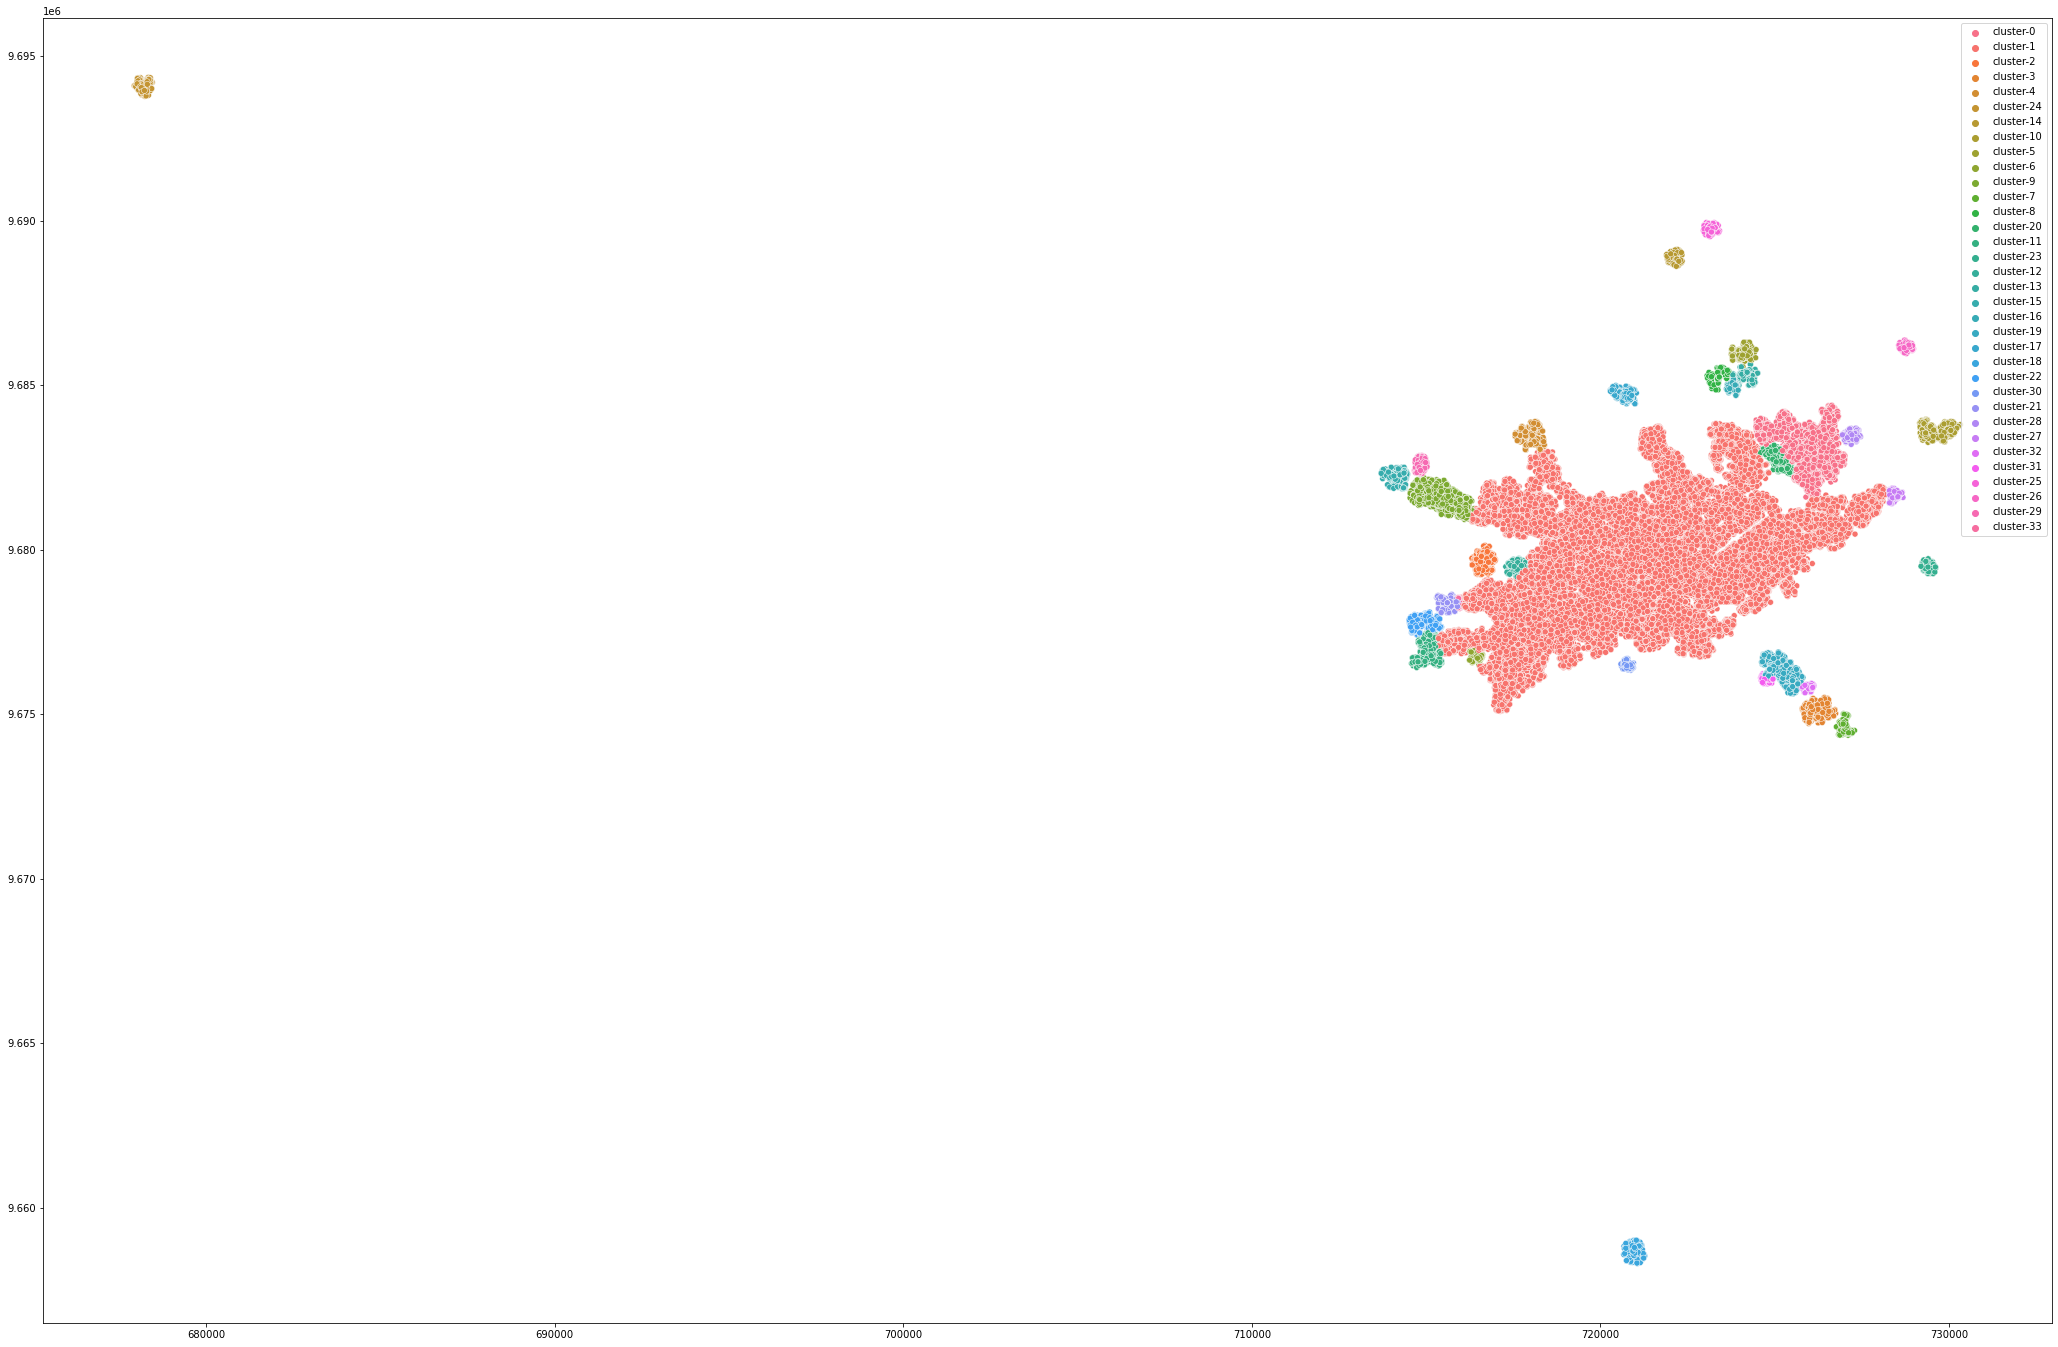

In [8]:
fig_meters_no_noise = plt.figure(figsize=(36, 24))
sns.scatterplot(xy_array_no_noise[:,0], xy_array_no_noise[:,1], hue=["cluster-{}".format(x) for x in labels_meters_no_noise])